In [1]:
%matplotlib inline
from IPython.display import Image
%config InlineBackend.figure_format = 'svg'
# export slides with terminal command: 
# jupyter nbconvert run_haats.ipynb --to slides --post serve --reveal-prefix http://cdn.bootcss.com/reveal.js/3.3.0
# or export pdf using  
# jupyter nbconvert run_haats.ipynb --to pdf
#then type "ctrl-c" in terminal and then go to html location to re-open slides directly
import bs4
from import_data import *
from estimation import*
np.random.seed(222)
plt.close("all")
from matplotlib import rc
# import ipdb

['/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py', '-f', '/Users/serginio/Library/Jupyter/runtime/kernel-c8d90474-d037-4c17-91e8-9008f3a242c4.json']
['/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py', '-f', '/Users/serginio/Library/Jupyter/runtime/kernel-c8d90474-d037-4c17-91e8-9008f3a242c4.json']
['/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py', '-f', '/Users/serginio/Library/Jupyter/runtime/kernel-c8d90474-d037-4c17-91e8-9008f3a242c4.json']


## Kalman filter example

Measurements: $$y_{t}=A_{0}+A_{1}X_{t}+\epsilon_{t} \qquad \text{with }\epsilon_{t}\sim N(0,\Phi)$$


States: $$X_{t}=U_0+U_1 X_{t_-1}+\eta_{t} \qquad \text{with } \eta_{t}\sim N(0,Q)$$


Assign model parameters

In [2]:
T_=100 #number of dates
m=14 #number of bonds
s = 4 #number of states
A0, A1, U0, U1, Q, Phi = np.mat(np.random.randn(m, 1)), np.mat(np.random.randn(m, s)), \
                            np.mat(np.random.randn(s, 1)), np.mat(np.diag(np.diag(np.random.rand(s, s)))), \
                            np.mat(np.diag(np.diag(np.random.rand(s, s)))), np.mat(np.diag(np.diag(np.random.rand(m, m))))

Simulate state variables (X) and the measurement (Y)

In [3]:
X0 = np.mat(np.random.randn(s,1))
X = np.mat(np.empty((T_,s))*np.nan)
Y = np.mat(np.empty((T_,m))*np.nan)
for t in range(T_):
    if t==0:
        X[t,:] = (U0+U1*X0+Q*np.mat(np.random.randn(s,1))).T
    else:   
        X[t,:] = (U0+U1*X[t-1,:].T +Q*np.mat(np.random.randn(4,1))).T
    Y[t,:] = (A0+A1*X[t,:].T+Phi*np.mat(np.random.randn(m,1))).T

X_df= pd.DataFrame(np.array(X),
                columns=['LN', 'S', 'C', 'LR'], index=pd.date_range('2000-01-01', periods=X.shape[0]))
Y_df= pd.DataFrame(np.array(Y),
                columns=['yield_'+str(i) for i in range(m)], index=pd.date_range('2000-01-01', periods=X.shape[0]))

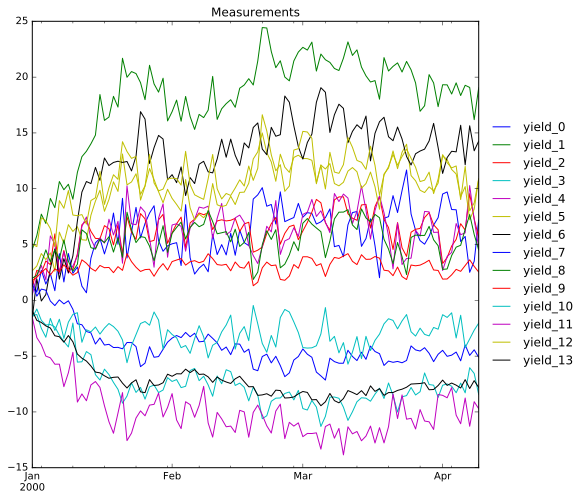

In [4]:
plt.rc('text', usetex=False)
fig, ax = plt.subplots(1)
figures = {'fig2': fig, 'ax_fig2': ax}
Y_df.plot(ax=figures['ax_fig2'],figsize=(8,8),linewidth=1)
plt.legend(loc='center left',fontsize=12,frameon=0, bbox_to_anchor=(1, 0.5))
figures['ax_fig2'].set_title('Measurements')
plt.show()

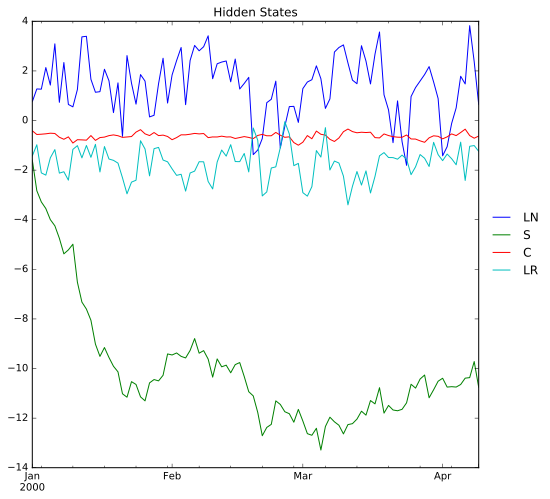

In [5]:
fig, ax = plt.subplots(1)
figures = {'fig2': fig, 'ax_fig2': ax}
X_df.plot(ax=figures['ax_fig2'],figsize=(8,8),linewidth=1)
plt.legend(loc='center left',fontsize=12,frameon=0, bbox_to_anchor=(1, 0.5))
figures['ax_fig2'].set_title('Hidden States')
plt.axes.labelcolor='black'
plt.show()

### Runing filter

In [6]:
kalman1 = Kalman(Y_df, A0, A1, U0, U1, Q, Phi,statevar_names = X_df.columns.values)
Ytt_filtered, Yttl_filtered, Xtt_filtered, Xttl_filtered, Vtt_filtered, Vttl_filtered, Gain_t_filtered, eta_t_filtered \
    = kalman1.filter()

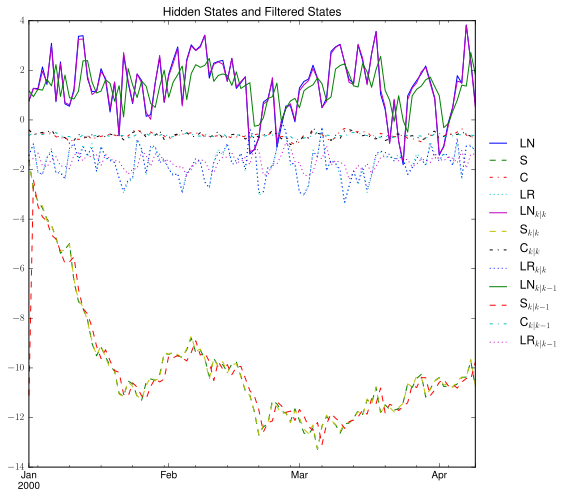

In [7]:
linestyles = ['-', '--', '-.', ':','-', '--', '-.', ':','-', '--', '-.', ':','-', '--', '-.', ':']

plt.rc('text', usetex=True)
fig, ax = plt.subplots(1)
figures = {'fig2': fig, 'ax_fig2': ax}
pd.concat(
    [X_df,
    Xtt_filtered.rename(columns={i:i+'$_{k|k}$' for i in Xtt_filtered.columns.values},inplace=False),
    Xttl_filtered.rename(columns={i:i+'$_{k|k-1}$' for i in Xtt_filtered.columns.values},inplace=False)]
, axis=1).plot(ax=figures['ax_fig2'],figsize=(8,8),style=linestyles,linewidth=1)
plt.legend(loc='center left',fontsize=12,frameon=0, bbox_to_anchor=(1, 0.5))
figures['ax_fig2'].set_title('Hidden States and Filtered States')
plt.axes.labelcolor='black'
plt.show()

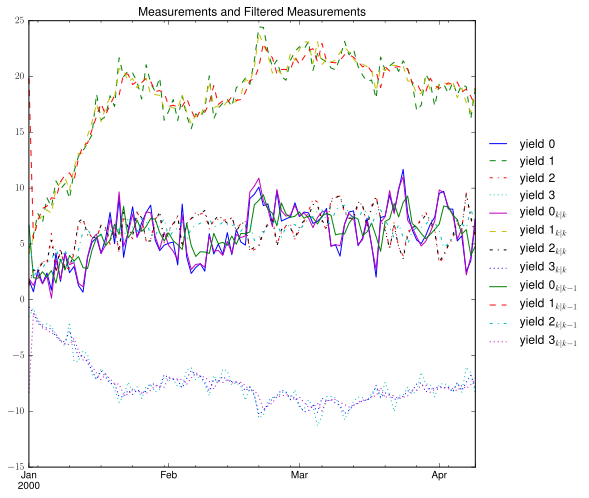

In [8]:
linestyles = ['-', '--', '-.', ':','-', '--', '-.', ':','-', '--', '-.', ':','-', '--', '-.', ':']
plt.rc('text', usetex=True)
fig, ax = plt.subplots(1)
figures = {'fig2': fig, 'ax_fig2': ax}
pd.concat(
    [Y_df.iloc[:,0:4].rename(columns={i:str.replace(i,'_','\_') for i in Y_df.columns.values},inplace=False),
    Ytt_filtered.iloc[:,0:4].rename(columns={i:str.replace(i,'_','\_')+'$_{k|k}$' for i in Ytt_filtered.columns.values},inplace=False),
    Yttl_filtered.iloc[:,0:4].rename(columns={i:str.replace(i,'_','\_')+'$_{k|k-1}$' for i in Yttl_filtered.columns.values},inplace=False)]
, axis=1).plot(ax=figures['ax_fig2'],figsize=(8,8),style=linestyles,linewidth=1)
plt.legend(loc='center left',fontsize=12,frameon=0, bbox_to_anchor=(1, 0.5))
figures['ax_fig2'].set_title('Measurements and Filtered Measurements')
plt.axes.labelcolor='black'
plt.show()

#### Runing smoother

In [9]:
XtT, VtT, Jt = kalman1.smoother(Xtt_filtered, Xttl_filtered, Vtt_filtered, Vttl_filtered, Gain_t_filtered, eta_t_filtered)

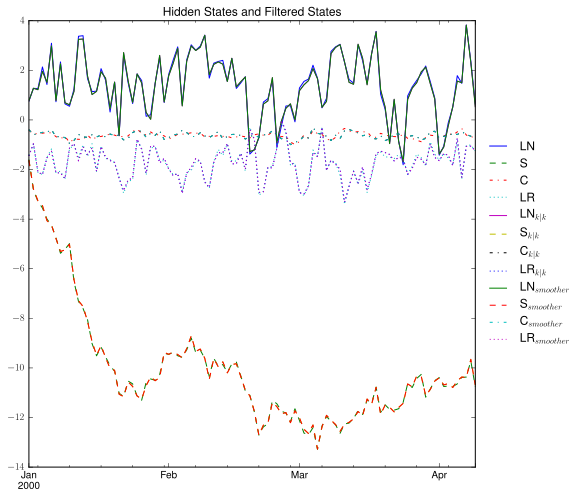

In [10]:
linestyles = ['-', '--', '-.', ':','-', '--', '-.', ':','-', '--', '-.', ':','-', '--', '-.', ':']

plt.rc('text', usetex=True)
fig, ax = plt.subplots(1)
figures = {'fig2': fig, 'ax_fig2': ax}
pd.concat(
    [X_df,
    Xtt_filtered.rename(columns={i:i+'$_{k|k}$' for i in Xtt_filtered.columns.values},inplace=False),
    XtT.rename(columns={i:i+'$_{smoother}$' for i in Xtt_filtered.columns.values},inplace=False)]
, axis=1).plot(ax=figures['ax_fig2'],figsize=(8,8),style=linestyles,linewidth=1)
plt.legend(loc='center left',fontsize=12,frameon=0, bbox_to_anchor=(1, 0.5))
figures['ax_fig2'].set_title('Hidden States and Filtered States')
plt.axes.labelcolor='black'
plt.show()

In [11]:
### Forecasts

In [12]:
forecast, forecast_std, forecast_cov = kalman1.forecast(Xtt_filtered, horizon=10)

processing time for forecast: 1.972899


In [13]:
#import seaborn as sns
import seaborn.apionly as sns #use sns.distplot but maintain the default matplotlib styling
sns.set("talk", font_scale=1, rc={"lines.linewidth": 1,"axes.labelcolor":'black',"text.color":'black'})

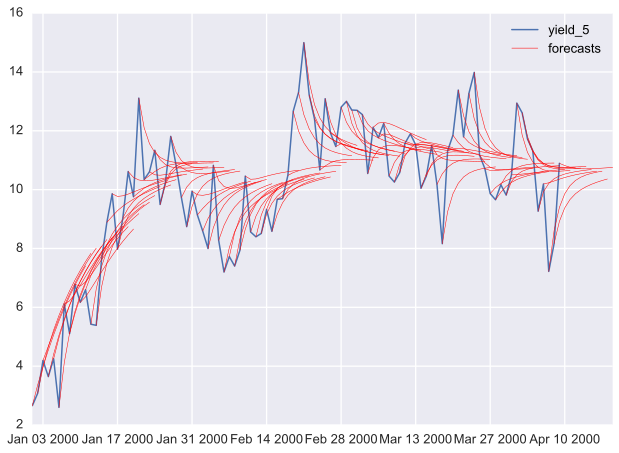

In [14]:
fig, ax = sns.plt.subplots(1)
line,=sns.plt.plot(forecast[['yield_5']].iloc[np.arange(0, forecast.shape[0], 10+1)].set_index(\
    forecast[['yield_5']].iloc[np.arange(0, forecast.shape[0], 10+1)].index.get_level_values('date')),linewidth=1.5\
    #,linestyle='solid', marker='o', markerfacecolor='blue', markersize=3.5
                  )
line.set_label('yield_5')
for t in forecast.index.get_level_values('date').unique():
    line,=sns.plt.plot(
        forecast[['yield_5']].iloc[forecast.index.get_level_values('date')==t,:].set_index(
        forecast[['yield_5']].iloc[forecast.index.get_level_values('date')==t,:].index.get_level_values('horizon'))
        ,color='red',linewidth=0.5)
line.set_label('forecasts')
sns.plt.legend()    
sns.plt.axes.labelcolor='black'
sns.plt.show()

In [ ]:
fig, ax = sns.plt.subplots(1,figsize=(14,8))
line,=sns.plt.plot(forecast[['yield_5']].iloc[np.arange(0, forecast.shape[0], 10+1)].set_index(\
    forecast[['yield_5']].iloc[np.arange(0, forecast.shape[0], 10+1)].index.get_level_values('date')),linewidth=1.5\
    #,linestyle='solid', marker='o', markerfacecolor='blue', markersize=3.5
                  )
line.set_label('yield_5: actual')
for t in forecast.index.get_level_values('date').unique():
    line,=sns.plt.plot(
        forecast[['yield_5']].iloc[forecast.index.get_level_values('date')==t,:].set_index(
        forecast[['yield_5']].iloc[forecast.index.get_level_values('date')==t,:].index.get_level_values('horizon'))
        ,color='red',linewidth=0.5)
    fill=plt.fill_between(forecast[['yield_5']].iloc[forecast.index.get_level_values('date')==t,:].index.get_level_values('horizon').values
                     , 
                     forecast[['yield_5']].iloc[forecast.index.get_level_values('date')==t,:].values[:,0]-
                     forecast_std[['yield_5']].iloc[forecast.index.get_level_values('date')==t,:].values[:,0],
                     forecast[['yield_5']].iloc[forecast.index.get_level_values('date')==t,:].values[:,0]+
                     forecast_std[['yield_5']].iloc[forecast.index.get_level_values('date')==t,:].values[:,0]
                    , facecolor='red', interpolate=True, alpha=.05
                    )
line.set_label('yield_5: forecasts')
fill.set_label('yield_5: forecasts stderr')
sns.plt.legend(loc='best')    
sns.plt.axes.labelcolor='black'
sns.plt.show()

In [ ]:
forecast_e, forecast_se, forecast_mse, forecast_rmse, forecast_mse_all, forecast_rmse_all = \
        kalman1.rmse(forecast)

In [ ]:
plt.rc('text', usetex=False)
fig, ax = plt.subplots(1)
figures = {'fig2': fig, 'ax_fig2': ax}
forecast_rmse.plot(ax=figures['ax_fig2'],figsize=(8,8),linewidth=1)
plt.legend(loc='center left',fontsize=12,frameon=0, bbox_to_anchor=(1, 0.5))
figures['ax_fig2'].set_title('RMSE')
plt.axes.labelcolor='black'
plt.show()